# Udacity Data Science Project
## What most influences Air BNB ratings and prices?
By Thierry Bemelmans, created on 2022-Aug-26. <br>
Licence GNU GPL: https://www.gnu.org/licenses/gpl-3.0.en.html

#### Data Science Methodology: leveraging the CRISP_DM framework
Details on the framework can be found here: https://www.ibm.com/docs/en/spss-modeler/saas?topic=dm-crisp-help-overview <br>
1. Business Understanding: background information, business objectives, success criteria
2. Data Understanding: describe the data, volumetrics, types, schema
3. Data Preparation: selecting rows / columns, missing value, calculation, blending, spliting train/test data
4. Data Modeling: run and tune data model(s) and parameters iteratively to increase model score
5. Result Evaluation: review business objectives and success criteria
6. Deployment: formal deployment in production of the model for business usage. Not applicable in this case. 

### 1. Business Understanding 
#### Background informaton: What is Air BNB?
'Airbnb began in 2008 when two designers who had space to share hosted three travellers looking for a place to stay. Now, millions of hosts and travellers choose to create a free Airbnb account so they can list their space and book unique accommodation anywhere in the world. And Airbnb experience hosts share their passions and interests with both travellers and locals' Source: https://www.airbnb.co.uk/help/article/2503/what-is-airbnb-and-how-does-it-work?_set_bev_on_new_domain=1661859435_ZWU1NjFhYWIwMjA1 
Air BnB data sets for numerous cities can be found at this URL http://insideairbnb.com/get-the-data/

#### Business Objectives: looking at the data, we will focus on the 3 following questions to answer
1. How are the BnB prices between Paris and Dublin comparable?
2. Where are the BNB geolocated in both town? Could we assume the more closer to the center, the pricier?
3. What features most influences / predict the pricing of a BNB?

### 2. Data Understanding & 3. Data Preparation
IN SCOPE: We will use the AirBNB listing.csv files from Seatle & Boston. Those files contain the list of key BNB, descriptions, key characteristics, score ratings and pricing.<br>
OUT OF SCOPE: For this exercise, we will not use the other 2 files provided: calendar.csv, reviews.csv. Futher analytics could use them for trending analytics and futher data enrichments. 

In [1]:
# Import key libraries and load data file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import datetime

# set display columns to see more per line
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 400)

Read files & combine both Boston and Seatle data sets & concatenate into one.

In [2]:
# Read Source Data AirBNB Boston and Seatle and concatenate them into one list
df_listing_Dublin= pd.read_csv("C:\ISRM Data\AirBNB\listings-Dublin-2022.csv.gz")
df_listing_Dublin['Listing']='Dublin'
df_listing_Paris = pd.read_csv(r"C:\ISRM Data\AirBNB\listings-Paris-2022.csv.gz")
df_listing_Paris['Listing']='Paris'
df_listing = pd. concat([df_listing_Dublin,df_listing_Paris ],ignore_index=True, sort=False)
# free up memory
del df_listing_Dublin
del df_listing_Paris

In [3]:
# Volumentrics - how big is the data set?
print(f'Rows: {df_listing.shape[0]}, columns: {df_listing.shape[1]}')

# Do we have features (columns) with all rows having a null values => to be scrapped
list_cols_null = df_listing.columns[df_listing.isna().all()].tolist()
print(f'\n{len(list_cols_null)} COLUMNS WITH ALL NULL VALUES (SCRAPPED): {list_cols_null}')
df_listing = df_listing.drop(list_cols_null, axis=1)
print(f'\nRows: {df_listing.shape[0]}, columns (after drop): {df_listing.shape[1]}')

Rows: 63803, columns: 75

3 COLUMNS WITH ALL NULL VALUES (SCRAPPED): ['neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated']

Rows: 63803, columns (after drop): 72


Look at top 10 columns with highest missing values.<br>
This will help us to see which columns could we scrap.
In this case, we will scrap the license & square_feet field as only available for 2% of rows.

In [4]:
# Get a simple dataframe with the columns, and % values filled (not NA)
col_list = df_listing.columns.tolist()
col_count = df_listing.count().values / df_listing.shape[0]
print(col_count.shape)
df_count = pd.DataFrame(col_count*100, columns=['Percent_filled'], index=None)
df_count.insert(loc=0, column='Field', value=np.array(col_list).transpose())

# show 10 top columns with lowest number of records incrementally
print(df_count.sort_values(by=['Percent_filled'], ascending=True).head(30))

(72,)
                          Field  Percent_filled
13                   host_about       48.739088
64                      license       50.177891
15           host_response_rate       55.906462
14           host_response_time       55.906462
26                neighbourhood       58.255881
6         neighborhood_overview       58.255881
20           host_neighbourhood       60.888986
16         host_acceptance_rate       61.166403
63          review_scores_value       78.568406
62       review_scores_location       78.574675
60        review_scores_checkin       78.579377
61  review_scores_communication       78.598185
58       review_scores_accuracy       78.598185
59    review_scores_cleanliness       78.604454
70            reviews_per_month       79.748601
57         review_scores_rating       79.748601
56                  last_review       79.748601
55                 first_review       79.748601
34                     bedrooms       84.516402
35                         beds   

               beds      bedrooms  accommodates
count  61963.000000  53171.000000  63004.000000
mean       1.735358      1.383273      3.023252
std        1.345969      0.967268      1.644475
min        1.000000      1.000000      1.000000
25%        1.000000      1.000000      2.000000
50%        1.000000      1.000000      2.000000
75%        2.000000      2.000000      4.000000
max       90.000000     50.000000     16.000000


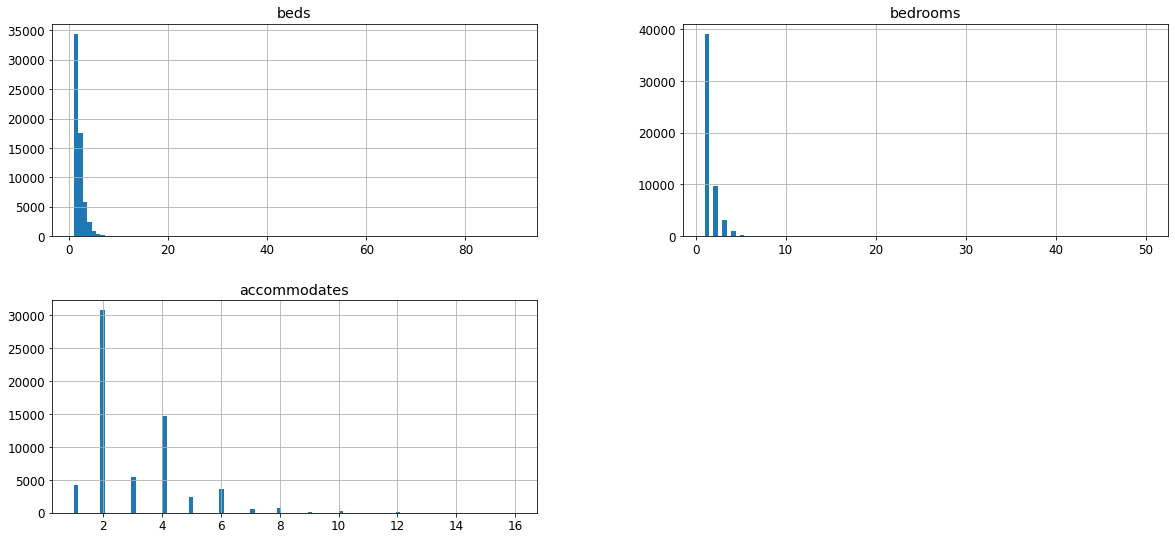

In [38]:
# looking at key distributions of beds, accommodates, bedrooms
fig, ax = plt.subplots(figsize=(20, 9))
plt.rcParams.update({'font.size': 12})
df_listing[['beds','bedrooms','accommodates']].hist(ax=ax, bins=100)
print(df_listing[['beds','bedrooms','accommodates']].describe())
plt.show();



In [6]:
# Which BNB have more than 80 beds? => They are hotels. 
df_listing.loc[df_listing['beds'] > 80].head()

id                            listing_url       scrape_id last_scraped                                               name                                        description                              neighborhood_overview                                        picture_url   host_id                                    host_url host_name  host_since                 host_location  \
32172  20747725  https://www.airbnb.com/rooms/20747725  20220606014139   2022-06-06  Charming Hotel the heart of Saint-Germain des ...  PERMANENT RECEPTION & ARRIVAL <br />Receptioni...  Saint-Germain des Prés is just the best place ...  https://a0.muscache.com/pictures/fcb3e758-d04e...  46443228  https://www.airbnb.com/users/show/46443228    Xavier  2015-10-13  Paris, Île-de-France, France   
32195  20691340  https://www.airbnb.com/rooms/20691340  20220606014139   2022-06-06  Historic family hotel rooms Saint-Germain des ...  PERMANENT RECEPTION & ARRIVAL <br />Receptioni...  Saint-Germain des Prés is just the best place ...  https://a0.muscache.com/pictures/1d3403ed-d09d...  46443228  https://www.airbnb.com/users/show/46443228    Xavier  2015-10-13  Paris, Île-de-France, France   
32197  20768013  https://www.airbnb.com/rooms/20768013  20220606014139   2022-06-06   La Louisiane the heart of Saint-Germain des Prés  PERMANENT RECEPTION & ARRIVAL <br />Receptioni...  Saint-Germain des Prés is just the best place ...  https://a0.muscache.com/pictures/4d138973-d1c8...  46443228  https://www.airbnb.com/users/show/46443228    Xavier  2015-10-13  Paris, Île-de-France, France   

                                              host_about host_response_time host_response_rate host_acceptance_rate host_is_superhost                                 host_thumbnail_url                                   host_picture_url              host_neighbourhood  host_listings_count  host_total_listings_count  host_verifications host_has_profile_pic  ... availability_30 availability_60  \
32172  WARNING: due to this platform technical limita...     within an hour               100%                  97%                 f  https://a0.muscache.com/im/pictures/user/9545a...  https://a0.muscache.com/im/pictures/user/9545a...  Saint-Germain-des-Prés - Odéon                 44.0                       44.0  ['email', 'phone']                    t  ...               8              26   
32195  WARNING: due to this platform technical limita...     within an hour               100%                  97%                 f  https://a0.muscache.com/im/pictures/user/9545a...  https://a0.muscache.com/im/pictures/user/9545a...  Saint-Germain-des-Prés - Odéon                 44.0                       44.0  ['email', 'phone']                    t  ...               4              20   
32197  WARNING: due to this platform technical limita...     within an hour               100%                  97%                 f  https://a0.muscache.com/im/pictures/user/9545a...  https://a0.muscache.com/im/pictures/user/9545a...  Saint-Germain-des-Prés - Odéon                 44.0                       44.0  ['email', 'phone']                    t  ...               1              15   

      availability_90  availability_365  calendar_last_scraped number_of_reviews number_of_reviews_ltm  number_of_reviews_l30d first_review  last_review  review_scores_rating review_scores_accuracy review_scores_cleanliness  review_scores_checkin  review_scores_communication  review_scores_location  review_scores_value  license  instant_bookable  calculated_host_listings_count  \
32172              54               270             2022-06-06               109                     2                       0   2017-09-05   2022-04-14                  4.61                   4.70                      4.48                   4.85                         4.85                    4.95                 4.71      NaN                 f                              44   
32195              48               264             2022-06-06       

### Normalize the scores <BR>
We will clean and normalize the score features to enable good comparison between BNB and easier analytics. <BR>
We will also look at price per persons it can accommodate.  <BR>

       review_scores_rating  review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  review_scores_communication  review_scores_location  review_scores_value
count          63803.000000            63803.000000               63803.000000           63803.000000                 63803.000000            63803.000000         63803.000000
mean               0.920247                0.951456                   0.919776               0.959622                     0.961778                0.956623             0.922031
std                0.125191                0.072955                   0.092505               0.070162                     0.069467                0.062342             0.081596
min                0.000000                0.000000                   0.000000               0.000000                     0.000000                0.000000             0.000000
25%                0.920247                0.951325                   0.910000               0.959529                   

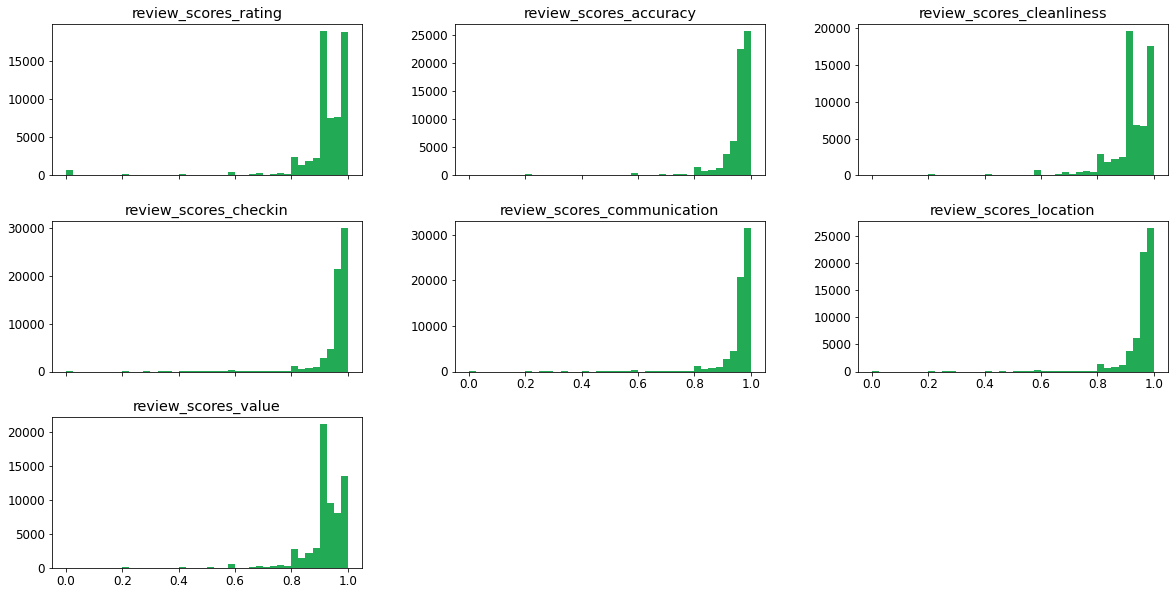

In [52]:
# looking at key distributions of score
# You can see the scores are pretty right skewed
cols_score =[col for col in df_listing.columns.tolist() if 'scores_' in col]

#normalize the score = score / max score, asumming bottom scale is 0, if N/A put the mean
for col in cols_score:
    max_of_col = df_listing[col].max()
    mean_of_col = df_listing[col].mean()
    df_listing[col] = df_listing[col].fillna(mean_of_col).astype(float) / max_of_col

print(df_listing[cols_score].describe())

print(f'Shape: {df_listing.shape}')
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(20, 10))
df_listing[cols_score].hist(ax=ax, bins=40, grid=False, figsize=(15,10), layout=(3,3), sharex=True, color='#22aa55')
ax.set_title = 'BnB Score Rating Distribution'
plt.show();


### Cleanse price fields:
1. Remove $ sign<br>
2. Remove n/a and 0 prices<br>
3. Calculate price per guest & show its distribution

Shape before dropping na on price: (63803, 72)
Shape after dropping na on price: (63642, 74)


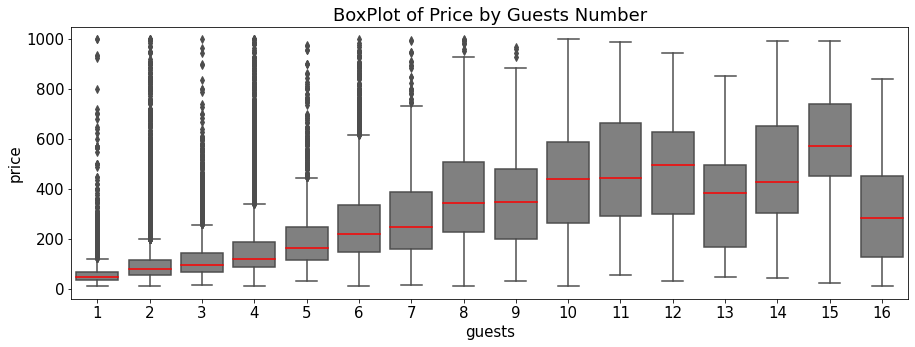

shape prior removal of outliers > 99 perct: (63642, 74)
shape after removal of outliers > 99 perct: (63004, 74)
              price  price_per_guest
count  63004.000000     63004.000000
mean     131.416323        46.436369
std      106.427099        36.745280
min       11.000000         0.000000
25%       65.000000        25.000000
50%       95.000000        37.000000
75%      157.000000        54.000000
max      694.000000       680.000000


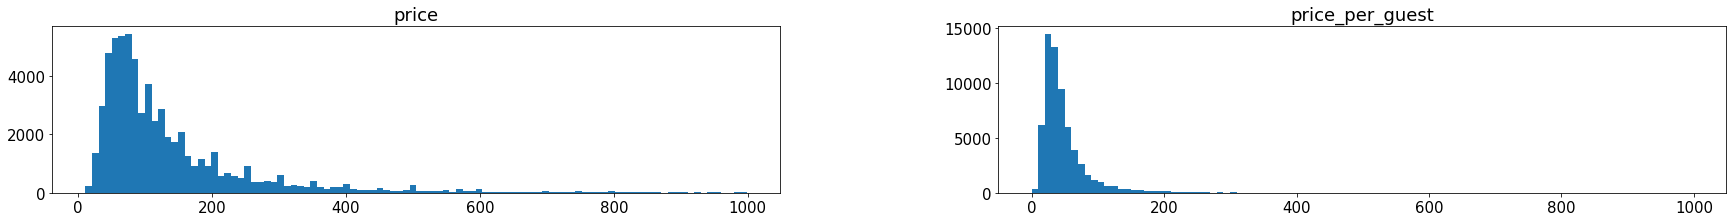

In [8]:
#convert price columns from string '$123.45' to float 123.45
import re
cols_price = ['price']
for col in cols_price:
    df_listing[col] = df_listing[col].astype(str).str.extract(r'(\d*\.\d*)').astype(float)    

# Only keep price > 10 to remove noisy records
print(f'Shape before dropping na on price: {df_listing.shape}')
df_listing = df_listing.loc[df_listing['price'] > 10]

def calc_guests(row):
# INPUT row of data frame
# OUTPUT: number of guests as 'accommodates', if 0, take number of bed as approximation, if still 0, set as 1
    value = row['accommodates'] 
    if value == 0:
        value = row['beds']
    if value == 0 or value is None:
        value = 1    
    return value

df_listing['guests'] = df_listing.apply(lambda row : calc_guests(row), axis=1).astype(int)

# get price/guests = price  / number of guests, using // to round to full $ for ease of review. 
df_listing['price_per_guest']= (df_listing['price']) // df_listing['guests']
cols_price.append('price_per_guest')
df_listing.dropna(subset=['price_per_guest', 'price', 'guests'])
print(f'Shape after dropping na on price: {df_listing.shape}')

# Visualize histogram of prices and scatter price/ number of guests
plt.rcParams.update({'font.size': 15})
GROUPBY = 'guests'
VALUE = 'price'
fig, ax = plt.subplots(figsize=(15, 5))
#sns.stripplot(data=df_listing,  y=VALUE, x=GROUPBY, jitter=0.4, alpha=0.05, ax=ax, color=[.2,.1,.9])     
sns.boxplot(data=df_listing, y = VALUE, x=GROUPBY, ax=ax, medianprops={'color':'red'}, color='Gray')    
plt.title('BoxPlot of Price by Guests Number')
plt.show()

df_listing[cols_price].hist(bins=100, grid=False, figsize=(30,15), layout=(4,2));

# remove upper outliers > 99% percentile
print(f'shape prior removal of outliers > 99 perct: {df_listing.shape}')
df_listing = df_listing.loc[df_listing['price'] < df_listing["price"].quantile(0.99)].copy()
print(f'shape after removal of outliers > 99 perct: {df_listing.shape}')
print(df_listing[cols_price].describe())




In [9]:
# horizontal boxplot in Seaborn
def my_boxplot(df, groupby, value, title, figsize):
    """
    INPUT: groupby = field you want to see in the y axis grouping rows
        value = field used for the x axis within the boxplot
        ax = axe to be used to draw the plot
    """
    fig, ax = plt.subplots(figsize=figsize, gridspec_kw=dict(left=0.1, right=0.9, bottom=0.1, top=0.7))
    #plt.rcParams.update({'font.size': 15, "figure.autolayout":True})
    sorted_index = df.groupby(groupby).median()[value].sort_values(ascending=False).index
    #ax = sns.stripplot(data=df_listing,  x=VALUE, y=GROUPBY, order=sorted_index, jitter=0.4, alpha=0.1, ax=ax, color='black')     
    ax= sns.boxplot(data=df, x=value, y=groupby, order = sorted_index, ax=ax, medianprops={'color':'red'})    
    ax.set(title=title)
    plt.show()

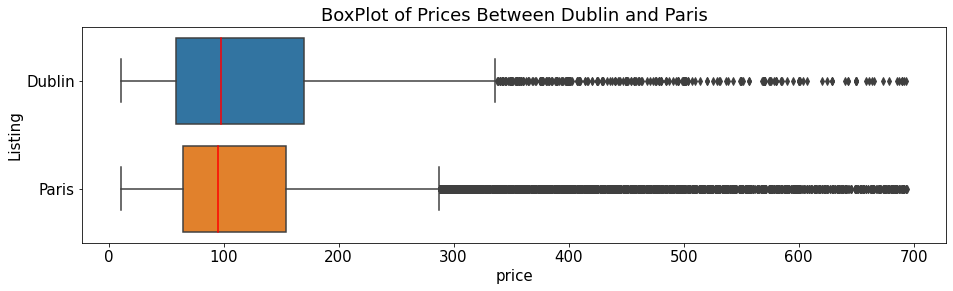

In [10]:
my_boxplot(df=df_listing, groupby='Listing', value='price', title='BoxPlot of Prices Between Dublin and Paris', figsize=(15,5))


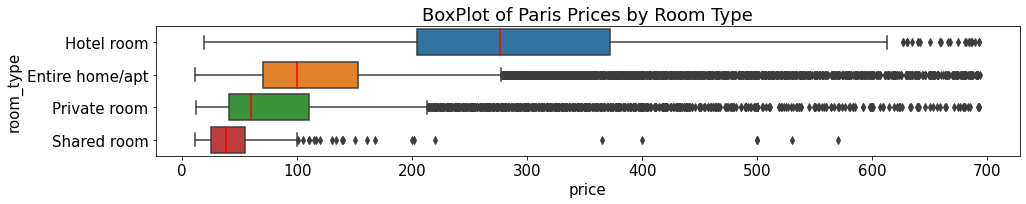

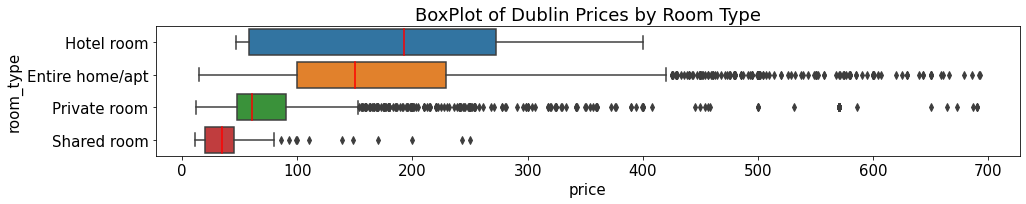

In [11]:
# Boxplot of price by room type
my_boxplot(df=df_listing.loc[(df_listing['Listing'] == 'Paris')], groupby='room_type', value='price', title='BoxPlot of Paris Prices by Room Type', figsize=(15,3))
my_boxplot(df=df_listing.loc[(df_listing['Listing'] == 'Dublin')], groupby='room_type', value='price', title='BoxPlot of Dublin Prices by Room Type', figsize=(15,3))

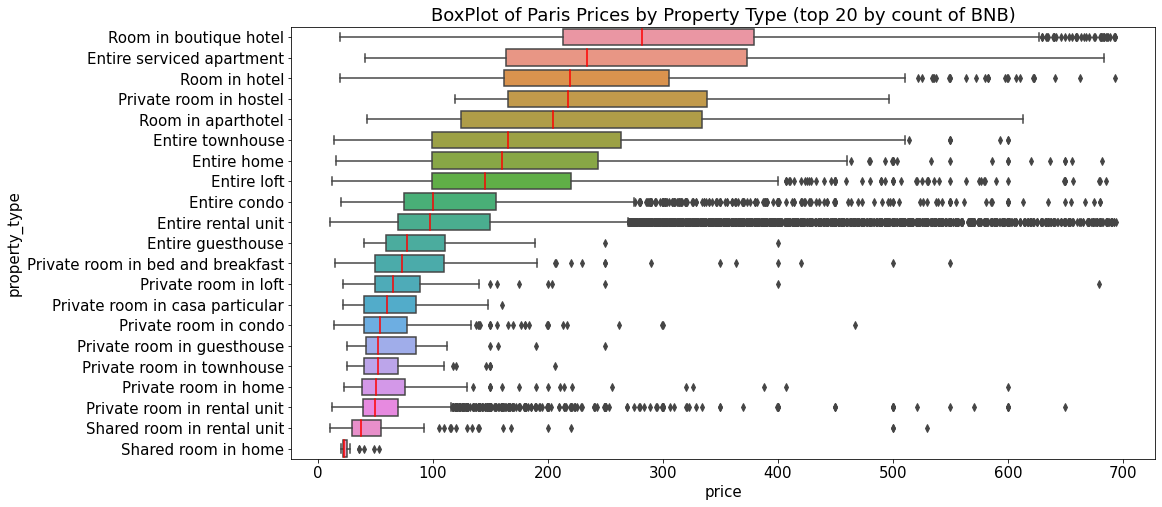

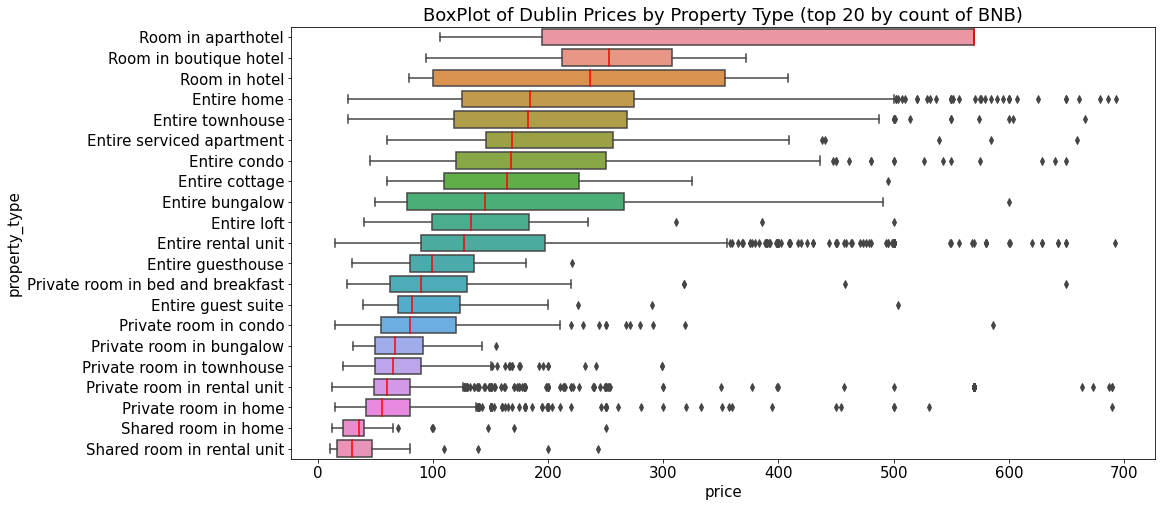

In [12]:
# Boxplot of price by property type
property_type_to_keep = df_listing.loc[df_listing['Listing'] == 'Paris'].groupby(by=['property_type'])['property_type'].count().sort_values(ascending=False).index.tolist()[:21]
my_boxplot(df=df_listing.loc[(df_listing['Listing'] == 'Paris') & (df_listing['property_type'].isin(property_type_to_keep))], groupby='property_type', value='price', title='BoxPlot of Paris Prices by Property Type (top 20 by count of BNB)', figsize=(15,10))

property_type_to_keep = df_listing.loc[df_listing['Listing'] == 'Dublin'].groupby(by=['property_type'])['property_type'].count().sort_values(ascending=False).index.tolist()[:21]
my_boxplot(df=df_listing.loc[(df_listing['Listing'] == 'Dublin') & (df_listing['property_type'].isin(property_type_to_keep))], groupby='property_type', value='price', title='BoxPlot of Dublin Prices by Property Type (top 20 by count of BNB)', figsize=(15,10))


Removing noisy fields: _URL columns, license.<br>
Also remove column shost_location, neighbourhood_group_cleansed as already in other colums city, state, neighbourhood_cleansed.<br>
Also remove zip code as not truely a numerical and already in geolocation columns


In [13]:
cols_url = [col for col in df_listing.columns.tolist() if '_url' in col]
cols_2_remove = cols_url + ['host_location', 'host_id']
for col in cols_2_remove:
    print(f'Check column {col} is in list: {col in df_listing.columns.tolist()}')
df_listing = df_listing.drop(cols_2_remove, axis=1)



Check column listing_url is in list: True
Check column picture_url is in list: True
Check column host_url is in list: True
Check column host_thumbnail_url is in list: True
Check column host_picture_url is in list: True
Check column host_location is in list: True
Check column host_id is in list: True


In [14]:
def df_analyze(df, verbose=True):
    # USER STORY: function to analyze the key data fields in a dataframe
    # INPUT: dataframe
    # OUTPUT: cols_numeric, cols_category
    # overal shape rows, cols

    # how many numeric / categorical columns
    cols_numeric = df.select_dtypes(include='number').columns.tolist()
    cols_category = df.select_dtypes(include='object').columns.tolist()

    # which cols types do we have an key stats
    if verbose: 
        print(f'Data frame shape: {df.shape}')
        print(f'{ len(cols_category)} CATEGORICAL COLUMNS: {cols_category}')
        print(f'\n{ len(cols_numeric)} NUMERICAL COLUMNS: {cols_numeric}')
    return cols_numeric, cols_category

# Analyze data listing.csv
cols_numeric, cols_category = df_analyze(df_listing)    

Data frame shape: (63004, 67)
28 CATEGORICAL COLUMNS: ['last_scraped', 'name', 'description', 'neighborhood_overview', 'host_name', 'host_since', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'amenities', 'has_availability', 'calendar_last_scraped', 'first_review', 'last_review', 'license', 'instant_bookable', 'Listing']

39 NUMERICAL COLUMNS: ['id', 'scrape_id', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', '

In [15]:


# key stats on numerical columns
df_listing[cols_numeric].describe()


id     scrape_id  host_listings_count  host_total_listings_count      latitude     longitude  accommodates      bedrooms          beds         price  minimum_nights  maximum_nights  minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm  availability_30  availability_60  availability_90  \
count  6.300400e+04  6.300400e+04         62992.000000               62992.000000  63004.000000  63004.000000  63004.000000  53171.000000  61963.000000  63004.000000    63004.000000    6.300400e+04            63004.000000            63004.000000            6.300400e+04            6.300400e+04            63004.000000            6.300400e+04     63004.000000     63004.000000     63004.000000   
mean   6.728599e+16  2.022061e+13            19.615126                  19.615126     49.361714      1.387811      3.023252      1.383273      1.735358    131.416323       79.393911    8.539165e+02               79.337820               82.248635            2.054152e+05            5.803774e+05               81.684491            3.506360e+05         3.646816        10.323313        19.463986   
std    1.897676e+17  6.754955e+05           186.244421                 186.244421      1.409104      2.703403      1.644475      0.967268      1.345969    106.427099      150.447411    3.984345e+04              150.620699              154.787666            2.095583e+07            3.527079e+07              154.304179            2.453876e+07         7.385328        16.662029        27.353532   
min    5.396000e+03  2.022061e+13             0.000000                   0.000000     48.803750     -6.526020      1.000000      1.000000      1.000000     11.000000        1.000000    1.000000e+00                1.000000                1.000000            1.000000e+00            1.000000e+00                1.000000            1.000000e+00         0.000000         0.000000         0.000000   
25%    1.382839e+07  2.022061e+13             1.000000                   1.000000     48.851430      2.300050      2.000000      1.000000      1.000000     65.000000        2.000000    6.000000e+01                2.000000                2.000000            9.900000e+01            3.050000e+02                2.000000            1.809500e+02         0.000000         0.000000         0.000000   
50%    2.995931e+07  2.022061e+13             1.000000                   1.000000     48.868330      2.342640      2.000000      1.000000      1.000000     95.000000        3.000000    1.125000e+03                3.000000                4.000000            1.125000e+03            1.125000e+03                3.000000            1.125000e+03         0.000000         0.000000         2.000000   
75%    4.658815e+07  2.022061e+13             2.000000                   2.000000     48.885730      2.366790      4.000000      2.000000      2.000000    157.000000       30.000000    1.125000e+03               30.000000               30.000000            1.125000e+03            1.125000e+03               30.000000            1.125000e+03         3.000000        14.000000        34.000000   
max    6.440439e+17  2.022061e+13          3404.000000                3404.000000     53.635000      2.487250     16.000000     50.000000     90.000000    694.000000     9999.000000    1.000000e+07             9999.000000             9999.000000            2.147484e+09            2.147484e+09             9999.000000            2.147484e+09        30.000000        60.000000        90.000000   

       availability_365  number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  review_scores_rating  review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  review_scores_communication  review_scores_location  review_scores_value  calculated_host_listings_count  calculated_host_listings_count_entire_homes  calculated_host_listings_count_private_rooms  \
count      63004.000000       63004.000000           63004.000000 

### Visualize the geolocation
Seeing the data on a map, helps to confirm if the geolocation influences the price.. which it seems to do.<br>
Note you can zoom in the map with your mouse scroll, like google map.<br>
Code Source reused: https://stackoverflow.com/questions/53233228/plot-latitude-longitude-from-csv-in-python-3-6

In [50]:
# if error pip install --upgrade nbformat
# Documentation https://plotly.com/python/scatter-plots-on-maps/
# https://plotly.github.io/plotly.py-docs/generated/plotly.graph_objects.Scattergeo.html

import plotly.express as px

# review_scores_rating  
# color scale see https://plotly.com/python/builtin-colorscales/


def show_me_map(df, listing, figsize=(10,10)):
    df = df_listing.loc[df_listing['Listing']==listing]
    fig = px.density_mapbox(df, lat='latitude', lon='longitude', radius=10, z='price',
                        center=dict(lat=df['latitude'].mean(), lon=df['longitude'].mean()), zoom=11,
                        mapbox_style="stamen-terrain", opacity=0.5, width=800, height=800)

    fig.update_geos(fitbounds="locations")
    fig.update_layout(title=f'AirBNB {listing} HeatMap', title_x=0.5, geo=dict(scope='europe', showland=True))
    fig.show()

show_me_map(df_listing, 'Dublin')    
show_me_map(df_listing, 'Paris')    

### Correlation analysis
Looking at correlations between the numerical variables helps to see which key columns mostly influence the price and ratings. 

''

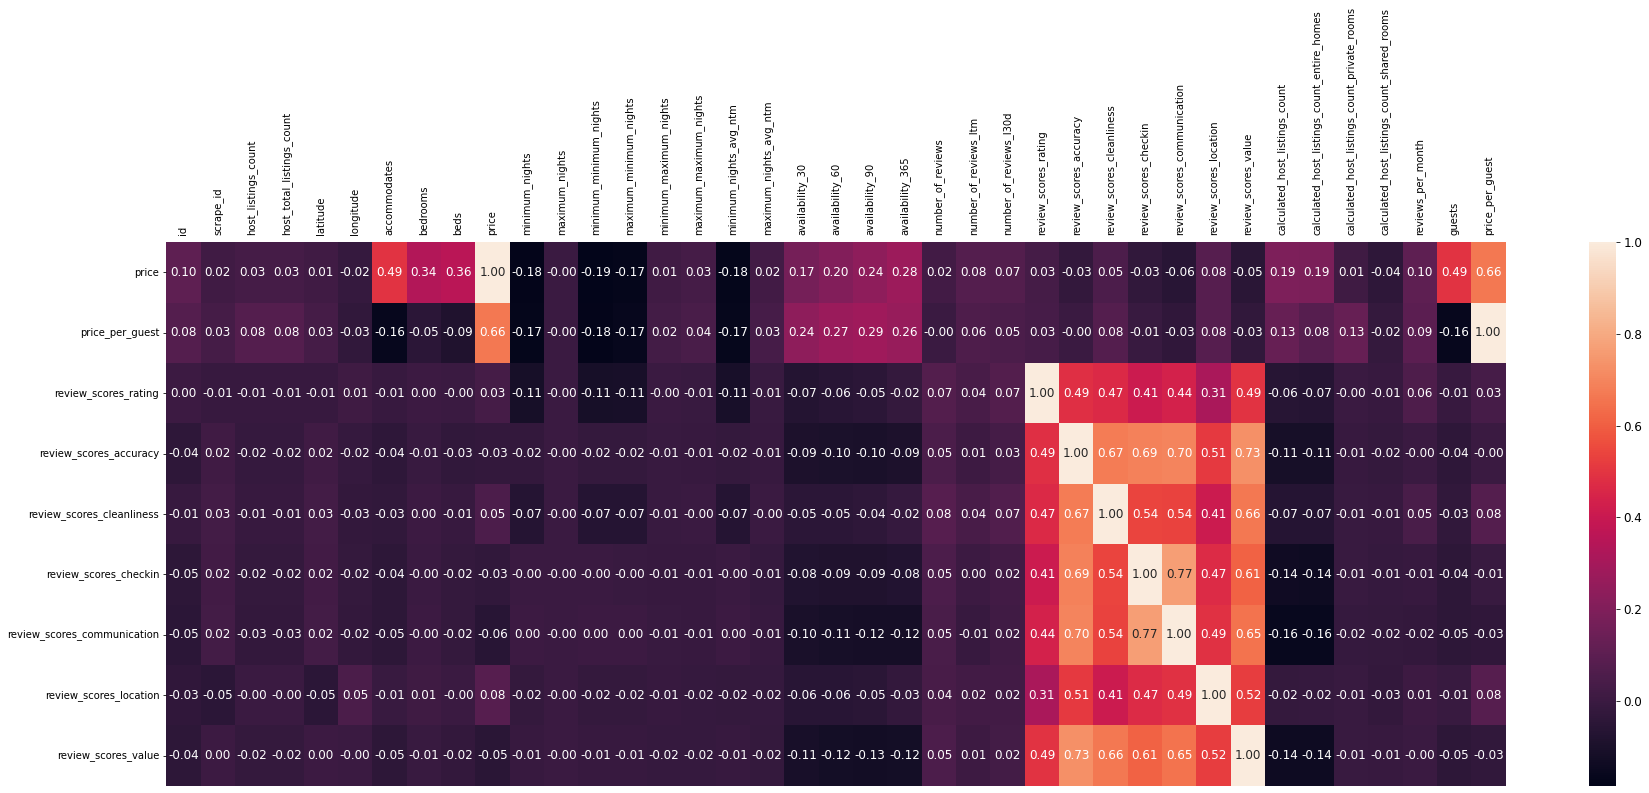

In [17]:
plt.figure(figsize = (30,10))
plt.rcParams.update({'font.size': 12})
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
sns.heatmap(df_listing.corr()[cols_price + cols_score].transpose(), annot=True, fmt='.2f' );
;

### Dates Columns
convert date to datetime
Convert date columns to number of days since last review date


In [18]:

now = datetime.datetime.now()
print(f'Today is : {now}')

def days_till_now(mydate):
# INPUT date in format yyyy-mm-dd as a string
# OUTPUT number of days till today

    days_till_now = 0
    try:
        #days_date = (now - datetime.strptime(mydate, '%Y-%m-%d')).days
        days_date = datetime.datetime.strptime(mydate, '%Y-%m-%d')
        days_till_now = (now - days_date).days
    except:
        pass
    return days_till_now

x ='2022-07-04'
print(f'{days_till_now(x)} days between {x} |--> {now}')

Today is : 2022-09-05 21:42:25.827533
63 days between 2022-07-04 |--> 2022-09-05 21:42:25.827533


In [19]:
#df_listing.drop(['calendar_last_scraped'], axis=1)

cols_date =['first_review' , 'last_review', 'host_since']
# check date format
print(df_listing[cols_date].dtypes)
print(df_listing[cols_date].head())

cols_till_now =[]   
# loop through dates col and get days till now, also drop date old column 
for col in cols_date:
    df_listing[col + '_to_now']= df_listing[col].astype(str).apply(lambda date: days_till_now(date))
    df_listing.drop(col, axis=1, inplace=True)
    cols_till_now.append((col + "_to_now"))

print(df_listing[cols_till_now].head())



first_review    object
last_review     object
host_since      object
dtype: object
  first_review last_review  host_since
0   2015-06-21  2019-10-31  2015-03-30
1   2019-08-25  2022-04-23  2019-06-03
2   2016-04-11  2021-10-26  2016-02-15
3   2017-05-25  2018-09-28  2016-08-12
4   2021-07-02  2022-06-06  2015-04-30
   first_review_to_now  last_review_to_now  host_since_to_now
0                 2633                1040               2716
1                 1107                 135               1190
2                 2338                 314               2394
3                 1929                1438               2215
4                  430                  91               2685


### Data Preparation - Text values
Note, we will only focus on the field 'Name' and 'Summary'. We will remove the other text fields to keep it simpler. <br>
In an ideal world, we should analyze each columns and test their potential impact on the business objectives. Comprehensive text analytics would need heavy computational means and time. <br>

In [20]:
list_text_to_keep = ['name', 'description', 'amenities']
list_test_to_remove = ['host_name', 'host_about', 'neighborhood_overview', 'neighbourhood', 'description', 'amenities', 'host_neighbourhood','license' ]
print(f'Shape before removing noisy text columns: {df_listing.shape}');

# Concatenate columns and remove na
df_listing['name_summary'] = df_listing['name'].fillna('').astype(str) + df_listing['description'].fillna('').astype(str) 

# Remove other text columns
df_listing.drop(list_test_to_remove, axis=1, inplace=True)
print(f'Shape after removing noisy text columns: {df_listing.shape}');

Shape before removing noisy text columns: (63004, 67)
Shape after removing noisy text columns: (63004, 60)


Text processing
1. Remove punctuations, stop words, lematize, do a vector count
2. Only keep words where overall count > 1% of total

In [21]:
import nltk
import string
# nltk.download() # uncomment if you need to download NLTK data

stopwords = nltk.corpus.stopwords.words('english')
english_words = set(nltk.corpus.words.words())
porterstemmer = nltk.PorterStemmer()
wordNetLemmatizer = nltk.WordNetLemmatizer()
print(f'Punctuation characters removed: {string.punctuation}')

def clean_text(text):
    #remove punctuation
    # use str() to ensure utf8 proper decoding
    text_nopunct = ''.join([char for char in text if char not in (string.punctuation)])

    #tokenize
    # only keep alphabetical words
    tokens = re.findall('[a-zA-Z]+', text_nopunct.lower())
    
    #remove stopwords & stem
    # stem = bring similar words to their 'root' or stem. example works, working, worked => work
    # stem is faster, but less accurate
    # tokens = [porterstemmer.stem(word) for word in tokens if word not in stopwords]
    
    # lemmatization = remove inflectional endings to return to the dictionary form of a word
    # lemma are more accurate but slower
    # remove also any non english words and stop words to keep our vector size small
    tokens = [wordNetLemmatizer.lemmatize(word) for word in tokens if word not in stopwords and word in english_words]
    return tokens

def clean_text_return_string(text):
    return ' ' .join(clean_text(text))
    
df_listing['name_summary_clean']= df_listing['name_summary'].apply(lambda x : clean_text_return_string(x.lower()))
print(f"After cleaning punctuations:\n {df_listing[['name_summary','name_summary_clean']].head()}") 

#NGRAMS = words in combinations. 
# docs: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
from sklearn.feature_extraction.text import CountVectorizer
n_gram_vect = CountVectorizer(ngram_range=(1,2), binary=False, max_features=5000)
X_counts = n_gram_vect.fit_transform(df_listing['name_summary_clean'])
X_cols_name = 'Name_Summary_' + n_gram_vect.get_feature_names_out()

#build a dataframe with the word binary count and the column names as the words
df_X_counts = pd.DataFrame(data=X_counts.toarray(), columns = X_cols_name )
print(f'Text Count vectorizer shape: {df_X_counts.shape}')

# put a prefix @TEXT_ to column names linked to text processing, this to easily spot them in the final model
prefix_column_list = ['@TEXT_' + col for col in df_X_counts.columns.tolist()]
df_X_counts.columns = prefix_column_list

# drop temporary columns used for string processing
df_listing.drop(['name_summary', 'name_summary_clean'], axis=1, inplace=True)

# concat dataframe columns (not rows) => axis=1
df_listing = pd.concat([df_listing, df_X_counts], axis=1)

# remove temporary dataframe from memory
del df_X_counts
print(df_listing.info());

Punctuation characters removed: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
After cleaning punctuations:
                                         name_summary                                 name_summary_clean
0  2 Cosy 2BD at Charming DUB SuburbsTwo cosy dou...  cosy charming dub cosy double bed room detache...
1  En-suite Double Room in Business LocationLarge...  double room business bedroom private bathroom ...
2  Large Double With Kingsize BedWe live in a lov...  large double live lovely detached dormer bunga...
3  Unique Country Home in Enniskerry - Green Room...  unique country home green walker wedding guest...
4  Seafront apartment, Clontarf, Dublin 3Seafront...  apartment apartment top floor story period res...
Text Count vectorizer shape: (63004, 5000)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 63786 entries, 0 to 62827
Columns: 5059 entries, id to @TEXT_Name_Summary_zoo
dtypes: float64(5042), object(17)
memory usage: 2.4+ GB
None


In [22]:
print(X_cols_name[:10])

['Name_Summary_able' 'Name_Summary_able bien' 'Name_Summary_able de'
 'Name_Summary_able en' 'Name_Summary_able enjoy' 'Name_Summary_able id'
 'Name_Summary_able la' 'Name_Summary_able pi' 'Name_Summary_able pour'
 'Name_Summary_able studio']


Convert rate string field 80% to 0.8 float, replace NA by 0

In [23]:
cols2convert = ['host_response_rate', 'host_acceptance_rate']
for col in cols2convert:
    df_listing[col] = df_listing[col].fillna('0').astype(str).apply(lambda x: x.replace('%',''))
    df_listing[col] = df_listing[col].astype(float)/100
print(df_listing[cols2convert].head())    


   host_response_rate  host_acceptance_rate
0                1.00                  0.29
1                1.00                  1.00
2                0.96                  0.63
3                1.00                  0.78
4                1.00                  0.96


In [24]:
# check columns of type 'Object' remaining 
df_listing.info(verbose=False)
cols_numeric, cols_category = df_analyze(df_listing, verbose=False)    
print(f'Cols with Object type:{cols_category}')
print(f'Cols with Object type:{df_listing[cols_category].nunique()}')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 63786 entries, 0 to 62827
Columns: 5059 entries, id to @TEXT_Name_Summary_zoo
dtypes: float64(5044), object(15)
memory usage: 2.4+ GB
Cols with Object type:['last_scraped', 'name', 'host_response_time', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'has_availability', 'calendar_last_scraped', 'instant_bookable', 'Listing']
Cols with Object type:last_scraped                  3
name                      60825
host_response_time            4
host_is_superhost             2
host_verifications            9
host_has_profile_pic          2
host_identity_verified        2
neighbourhood_cleansed       24
property_type                87
room_type                     4
bathrooms_text               35
has_availability              2
calendar_last_scraped         3
instant_bookable              2
Listing                       2
dt

### Data Preparation - host verification ['email', 'phone', 'facebook', 'google', 'linkedin', 'amex', 'reviews', 'jumio'] => binary vector
We will use a sklearn Countvectorizer for it to generate a binary vector for all types of verifications, were 1 = has the verification type and 0 = has not

In [25]:
#NGRAMS = words in combinations. 
# docs: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# remove the []' characters and replace , with a blank
# remove the non alpha characters and replace , with a blank
df_listing['host_verifications_clean'] = df_listing['host_verifications'].fillna('N/A').str.replace("[^a-zA-Z ]", '')
print(df_listing['host_verifications_clean'].unique()[:3])

from sklearn.feature_extraction.text import CountVectorizer
n_gram_vect = CountVectorizer(ngram_range=(1,1), binary=True)
X_counts = n_gram_vect.fit_transform(df_listing['host_verifications_clean'])
X_cols_name = 'host_verifications_' + n_gram_vect.get_feature_names_out()

#build a dataframe with the word binary count and the column names as the words
df_X_counts = pd.DataFrame(data=X_counts.toarray(), columns = X_cols_name )
print(f'Text Count vectorizer prior stripping low count: {df_X_counts.shape}')

# drop temporary columns used for string processing
df_listing.drop(['host_verifications_clean', 'host_verifications'], axis=1, inplace=True)

# concat dataframe columns (not rows) => axis=1
df_listing = pd.concat([df_listing, df_X_counts], axis=1)

C:\Users\tbemelma\AppData\Local\Temp\9\ipykernel_34524\653579513.py:6: FutureWarning:

The default value of regex will change from True to False in a future version.



['email phone' 'phone' 'email phone workemail']
Text Count vectorizer prior stripping low count: (63786, 6)


In [26]:
print(f'Dflisting shape: {df_listing.shape}')
cols_numeric, cols_category = df_analyze(df_listing, verbose=False) 
print(cols_category)

Dflisting shape: (63803, 5064)
['last_scraped', 'name', 'host_response_time', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'has_availability', 'calendar_last_scraped', 'instant_bookable', 'Listing']


In [27]:
# clear the numerics from the field bathrooms_text
df_listing['bathrooms_text'] = df_listing['bathrooms_text'].str.replace('[^a-zA-Z ]', '')
print(df_listing['bathrooms_text'].unique()[:20])

[' shared bath' ' private bath' ' shared baths' ' bath' ' baths' nan
 'Shared halfbath' 'Halfbath' 'Private halfbath']


C:\Users\tbemelma\AppData\Local\Temp\9\ipykernel_34524\908041023.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.



### Data Preparation - Categorical Columns to numerical values

In [28]:
def create_dummy_df(df, cat_cols, dummy_na=True):
    '''
    ORIGINAL SOURCE: UDACITY - Data Science nanodegree
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col].str.lower(), prefix=col, prefix_sep='=', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df  

# Get the categorical cols and remove the info only ones
cols_numeric, cols_category = df_analyze(df_listing, verbose=False) 
cols_info_only = ['id', 'scrape_id','name', 'summary', 'host_name', 'calendar_last_scraped']

for col in cols_info_only:
    try:
        cols_category.remove(col)
    except:
        print(f'Column not in category column (likely numeric): {col}')

print(f'\nColums category without info columns: {cols_category}')

#Dummy categorical variables
df_listing2 = df_listing.copy()

# Check N/A values
print(f'Cell count in DF with N/A: {df_listing2[cols_category].isna().sum().sum()}')
print(f'Columns in DF count of unique values: {df_listing2[cols_category].nunique()}')

df_listing2 = create_dummy_df(df_listing2, cols_category, dummy_na=True)
#df_listing2 = df_listing2.drop(cols_category, axis=1)




Column not in category column (likely numeric): id
Column not in category column (likely numeric): scrape_id
Column not in category column (likely numeric): summary
Column not in category column (likely numeric): host_name

Colums category without info columns: ['last_scraped', 'host_response_time', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'has_availability', 'instant_bookable', 'Listing']
Cell count in DF with N/A: 37648
Columns in DF count of unique values: last_scraped               3
host_response_time         4
host_is_superhost          2
host_has_profile_pic       2
host_identity_verified     2
neighbourhood_cleansed    24
property_type             87
room_type                  4
bathrooms_text             8
has_availability           2
instant_bookable           2
Listing                    2
dtype: int64


In [29]:
cols_numeric, cols_category = df_analyze(df_listing2, verbose=False) 
print(df_listing2.info())
print(f'INFO ONLY: {cols_info_only}')
print(f'CATEGORY: {cols_category[:30]}')
print(f'NUMERICS: {cols_numeric[:30]}')
cols_price = [col for col in cols_numeric if "price" in col.lower()]
print(f'PRICE: {cols_price}')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 63803 entries, 0 to 63764
Columns: 5194 entries, id to Listing=nan
dtypes: float64(5050), object(2), uint8(142)
memory usage: 2.4+ GB
None
INFO ONLY: ['id', 'scrape_id', 'name', 'summary', 'host_name', 'calendar_last_scraped']
CATEGORY: ['name', 'calendar_last_scraped']
NUMERICS: ['id', 'scrape_id', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness']
PRICE: ['price', 'price_per_guest', '@TEXT_Name_Summary_inclu

In [30]:
y_col_name = 'price'
print(f'Before cleaning na: {df_listing2.shape}')
df_listing2[y_col_name].dropna(inplace=True)
df_listing2.fillna(0,inplace=True)
print(f'after cleaning na: {df_listing2.shape}')

print(f'Cell in DF with N/A: {df_listing2.isna().sum().sum()}')

Before cleaning na: (63803, 5194)
after cleaning na: (63803, 5194)
Cell in DF with N/A: 0


In [31]:
print(df_listing2[cols_category].nunique())

name                     60826
calendar_last_scraped        4
dtype: int64


### Modeling
r2 Score measures the performance of our Model, comparing predicted value by the model vs actual values. <br>
Mathematically: r2 score = 1 - sum ( [y_pred - y_mean]^2 )/ sum([y_actual - y_mean]^2)<br>
So the closer you are to 1, the more your predictions are in line with the actuals.<br>

See excellent article here: https://stephenallwright.com/good-r-squared-value/

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

def fit_predict(X, y):
    """
    USER STORY: function to split the train/ test data, fit a model and return the model and its r2score
    INPUT: X = df of X numerical features, y=dataframe of the value to be predicted
    OUTPUT: X_train, X_test, y_train, y_test, linear model, r2 score
    """

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

    lm_model = LinearRegression() # Instantiate
    lm_model.fit(X_train, y_train) #Fit
            
    #Predict and score the model
    y_test_preds = lm_model.predict(X_test) 

    #Rsquared and y_test
    rsquared_score = r2_score(y_test, y_test_preds)
    length_y_test = len(y_test)

    print(f"The model r2 score = {rsquared_score:.4f}, fit on {length_y_test} rows.")
    return X_train, X_test, y_train, y_test, lm_model, rsquared_score

#Split into explanatory and response variables
cols_numeric_cleaned = [col for col in cols_numeric if col not in cols_info_only and col not in cols_price ]
y = df_listing2[y_col_name]
X = df_listing2[cols_numeric_cleaned]
X_train, X_test, y_train, y_test, lm_model, rsquared_score = fit_predict(X, y)


The model r2 score = 0.4857, fit on 19141 rows.


## 5.Results Evaluation<br>
### Model Insights - what most influence our price per guest?
Looking at the correlation coeficient of the model, you can see the parameters that most influence the y prediction. <br>
R-Squared value	Interpretation <br>
0.75 - 1	Significant amount of variance explained<br>
0.5 - 0.75	Good amount of variance explained<br>
0.25 - 0.5	Small amount of variance explained<br>
0 - 0.25	Little to no variance explained<br>


In [33]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def coef_weights(lm_model, X_train):
    '''
    Function code originally from UDACITY DataScience Learn course
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    
    coefs_df = pd.DataFrame()
    coefs_df['Feature Name'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model, X_train)

In [34]:
# check to features impacting prices
df_top_features = coef_df.sort_values('abs_coefs', ascending=False)
print(df_top_features)
df_top_features.to_csv('c:/temp/model_coeficients.csv')

                                      Feature Name         coefs     abs_coefs
6                                     accommodates  5.772636e+05  5.772636e+05
36                                          guests -5.772387e+05  5.772387e+05
56             @TEXT_Name_Summary_absolutely ready  6.382746e+03  6.382746e+03
5044                       last_scraped=2022-06-08  5.648421e+03  5.648421e+03
5183                                 Listing=paris  4.889488e+03  4.889488e+03
...                                            ...           ...           ...
5151  property_type=shared room in casa particular  7.105427e-15  7.105427e-15
5136            property_type=private room in tent  6.217249e-15  6.217249e-15
5154      property_type=shared room in guest suite -5.107026e-15  5.107026e-15
5158         property_type=shared room in ice dome  4.440892e-15  4.440892e-15
5165                           property_type=tower  2.886580e-15  2.886580e-15

[5185 rows x 3 columns]



Feature = property_type=


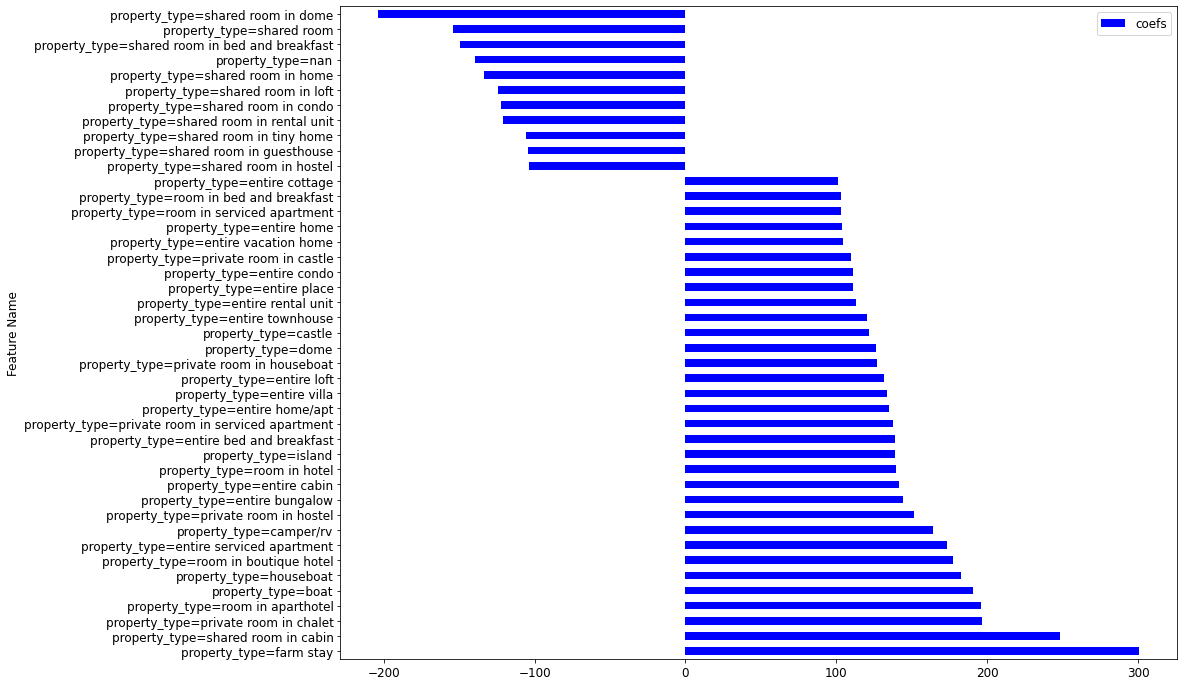


Feature = room_type=


In [44]:
#A quick look at the top results
list_feature_keys_2_visualize = ['property_type', 'room_type']
list_feature_keys_2_visualize = [col + '=' for col in list_feature_keys_2_visualize]

for feature_key in list_feature_keys_2_visualize:
    try:
        print(f'\nFeature = {feature_key}')
        df_results = coef_df.loc[(coef_df['Feature Name'].str.contains(feature_key)) & (abs(coef_df['coefs']) > 100)].sort_values('coefs', ascending=False)
        if df_results.shape[0] > 1:
            try: 
                df_results.plot.barh(x='Feature Name', y='coefs', rot=0, figsize=(15,12), color='blue')
            except:
                print(f'Issue with feature: {feature_key}')
            plt.show();
    except:
        print(f'issue with feature: {feature_key}')    



Feature = _score


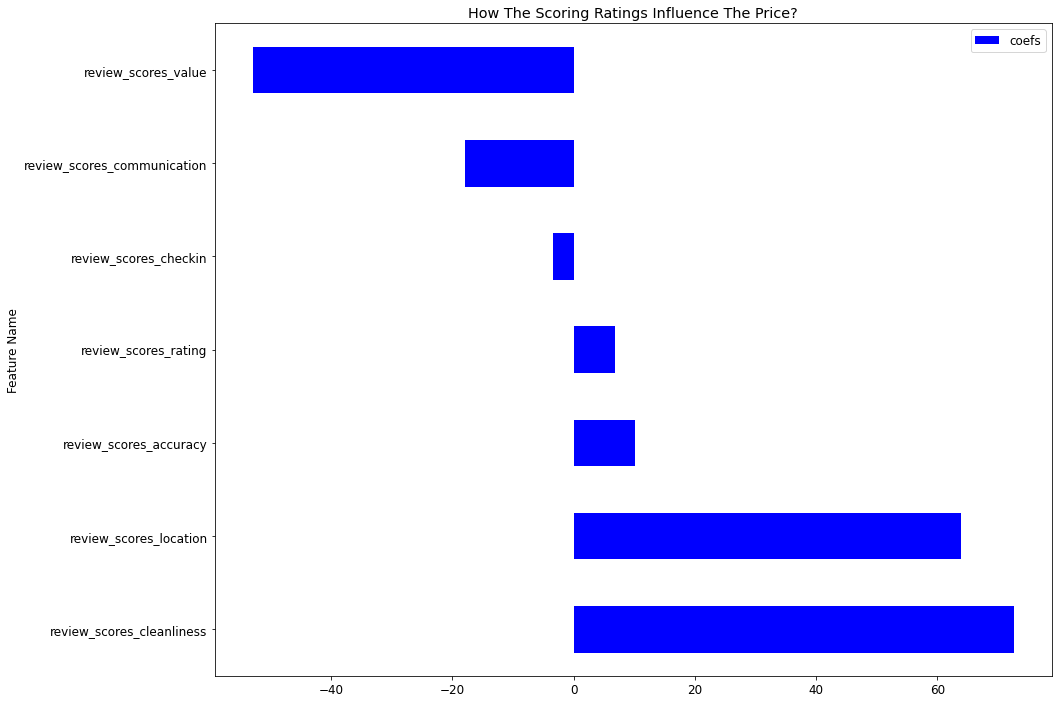

In [49]:
#A quick look at the top results
list_feature_keys_2_visualize = ['_score']

for feature_key in list_feature_keys_2_visualize:
    try:
        print(f'\nFeature = {feature_key}')
        df_results = coef_df.loc[coef_df['Feature Name'].str.contains(feature_key)].sort_values('coefs', ascending=False)
        if df_results.shape[0] > 1:
            try: 
                df_results.plot.barh(x='Feature Name', y='coefs', rot=0, figsize=(15,12), color='blue', title='How The Scoring Ratings Influence The Price?')
            except:
                print(f'Issue with feature: {feature_key}')
            
            plt.show();
    except:
        print(f'issue with feature: {feature_key}')    